In [1]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import torch

In [3]:
dataset = load_dataset("MagedSaeed/xlsum_arabic_experimental")
train_data = dataset["train"]
test_data = dataset["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/574 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/80.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4689 [00:00<?, ? examples/s]

In [4]:
train_data = dataset["train"].select(range(10000))
test_data = dataset["test"].select(range(1400))

In [5]:
columns_to_remove = ["gem_id", "url", "title", "references"]
train_data = train_data.remove_columns(columns_to_remove)
test_data = test_data.remove_columns(columns_to_remove)
print("columns in train_data:", train_data.column_names)
print("columns in test_data:", test_data.column_names)

columns in train_data: ['target', 'text']
columns in test_data: ['target', 'text']


Average text length: 423
Maximum text length: 4618
95% of texts below: 1164

Average summary length: 25
Maximum summary length: 222
95% of summaries below: 42


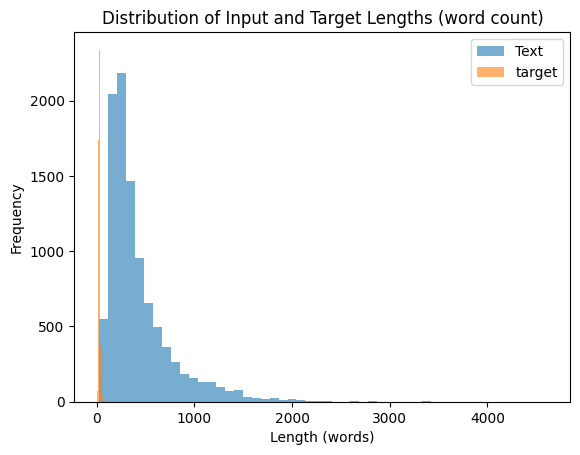

In [6]:
import matplotlib.pyplot as plt

data = train_data

input_lengths = [len(myData["text"].split()) for myData in data]
target_lengths = [len(myData["target"].split()) for myData in data]

print("Average text length:", sum(input_lengths) // len(input_lengths))
print("Maximum text length:", max(input_lengths))
print("95% of texts below:", sorted(input_lengths)[int(0.95 * len(input_lengths))])

print("\nAverage summary length:", sum(target_lengths) // len(target_lengths))
print("Maximum summary length:", max(target_lengths))
print("95% of summaries below:", sorted(target_lengths)[int(0.95 * len(target_lengths))])

plt.hist(input_lengths, bins=50, alpha=0.6, label='Text')
plt.hist(target_lengths, bins=50, alpha=0.6, label='target')
plt.title("Distribution of Input and Target Lengths (word count)")
plt.xlabel("Length (words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [7]:
mean_input_length = int(np.mean(input_lengths))
mean_target_length = int(np.mean(target_lengths))

print(f"Using max_length {mean_input_length} for Text Input and {mean_target_length} for Target.")


Using max_length 423 for Text Input and 25 for Target.


In [8]:
model_name = "UBC-NLP/AraT5-base"
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


Loading model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/2.44M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

In [9]:
def preprocess_function(examples):
    inputs = tokenizer(examples["text"], max_length=mean_input_length, truncation=True, padding="max_length")
    targets = tokenizer(examples["target"], max_length=mean_target_length, truncation=True, padding="max_length")
    return inputs

In [10]:

print("Applying preprocessing to dataset...")
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Applying preprocessing to dataset...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [11]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b709880c27f300e790c1230c8fc1f2ede0cf2edb186938d0e6ba5b74c9ca1096
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [12]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    print("\nEvaluation ROUGE scores:", {k: round(v * 100, 4) for k, v in result.items()})
    return {k: round(v * 100, 4) for k, v in result.items()}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_arat5_xlsum",
    eval_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=7,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False,
    report_to="none"
)

In [18]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-18-32089b685c35>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [19]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable:,} / {total:,} ({(trainable/total)*100:.4f}%)")


Trainable parameters: 282,770,688 / 282,770,688 (100.0000%)


In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,4.988800,4.455836,0.166700,0.000000,0.166700,0.166700
2,4.420400,3.808139,0.071400,0.000000,0.071400,0.071400
3,3.846800,3.485169,0.452400,0.000000,0.464300,0.452400
4,3.791700,3.392768,0.266700,0.000000,0.285700,0.285700
5,3.385300,3.339947,0.734700,0.107100,0.738100,0.738100
6,3.229400,3.311631,0.742900,0.107100,0.745200,0.742900
7,3.109100,3.314302,0.761900,0.107100,0.761900,0.738100



Evaluation ROUGE scores: {'rouge1': np.float64(0.1667), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.1667), 'rougeLsum': np.float64(0.1667)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.0714), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0714), 'rougeLsum': np.float64(0.0714)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.4524), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.4643), 'rougeLsum': np.float64(0.4524)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.2667), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.2857), 'rougeLsum': np.float64(0.2857)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.7347), 'rouge2': np.float64(0.1071), 'rougeL': np.float64(0.7381), 'rougeLsum': np.float64(0.7381)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.7429), 'rouge2': np.float64(0.1071), 'rougeL': np.float64(0.7452), 'rougeLsum': np.float64(0.7429)}

Evaluation ROUGE scores: {'rouge1': np.float64(0.7619), 'rouge2': np.float64(0.1071), 'rougeL': np.float64(0.76

TrainOutput(global_step=8750, training_loss=3.9634190340314595, metrics={'train_runtime': 2992.2674, 'train_samples_per_second': 23.394, 'train_steps_per_second': 2.924, 'total_flos': 3.52172717568e+16, 'train_loss': 3.9634190340314595, 'epoch': 7.0})

In [24]:
model.save_pretrained("finetuned_araT5_xlsum")
tokenizer.save_pretrained("finetuned_araT5_xlsum")

('finetuned_araT5_xlsum/tokenizer_config.json',
 'finetuned_araT5_xlsum/special_tokens_map.json',
 'finetuned_araT5_xlsum/spiece.model',
 'finetuned_araT5_xlsum/added_tokens.json',
 'finetuned_araT5_xlsum/tokenizer.json')

In [39]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "finetuned_araT5_xlsum"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

text = (
    """   في حادثة مروعة في دمشق، قُتل رجل مسن داخل منزله في حي ساروجة
    وأفادت وزارة الداخلية بأن الجناة سرقوا من خزنة حديدية مبلغ 3.2 مليون ليرة سورية، مسدساً حربياً، هاتفاً محمولاً.
     تمكنت السلطات من إلقاء القبض على ثمانية أشخاص متورطين في الجريمة،
    حيث اعترفوا بتفاصيل الجريمة أثناء التحقيقات."""
)

inputs = tokenizer(text, return_tensors="pt", max_length=mean_input_length, truncation=True)

summary_ids = model.generate(inputs["input_ids"], max_length=mean_target_length, num_beams=4, early_stopping=True)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("📌 النص الأصلي:")
print(text)
print("\n📝 التلخيص:")
print(summary)


📌 النص الأصلي:
   في حادثة مروعة في دمشق، قُتل رجل مسن داخل منزله في حي ساروجة
    وأفادت وزارة الداخلية بأن الجناة سرقوا من خزنة حديدية مبلغ 3.2 مليون ليرة سورية، مسدساً حربياً، هاتفاً محمولاً.
     تمكنت السلطات من إلقاء القبض على ثمانية أشخاص متورطين في الجريمة،
    حيث اعترفوا بتفاصيل الجريمة أثناء التحقيقات.

📝 التلخيص:
قُتل رجلا في العاصمة السورية دمشق في محاولة لسرقة خزنة معدنية.


In [40]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [41]:
!cp /content/finetuned_araT5_xlsum/model.safetensors "/content/drive/MyDrive/MyModels/"


cp: cannot create regular file '/content/drive/MyDrive/MyModels/': Not a directory
